### Calculate Differences Between Three Models on Unlabeled Images

In [152]:
# basic libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time
import os

# brtdevkit
import brtdevkit
from brtdevkit.core.db import DBConnector
from brtdevkit.core.db.db_filters import *  # We need this for pre-defined filters, e.g., ProjectFilter, DatetimeFilter
import brtdevkit.util.s3 as brt_s3

# dl-core
import brtdl.metrics
from brtdl.metrics.evaluate_metrics import evaluate_metrics
from brtdl import inference, default_arguments
from brtdl.data import canonical_types, SampleKeys
from brtdl.data.dataset import PathDataset, PredictionDataset
from brtdl.data.loaders import im_reader, npy_reader
from brtdl.transforms import SegmentationTransform
from brtdl.visual import colorize_segmentation

import skimage.transform as skt
import skimage
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

from warnings import filterwarnings
filterwarnings("ignore")

In [153]:
# Retreive example df

def get_shasta_data(filters={}, start=None, end=None, limit=None):
    """
    Query relevant Shasta data for calculations. 
    """
    start_time = time.time()
    connector = DBConnector()
    img_filters = {'project_name': 'shasta', **filters}
    if start is not None or end is not None:
        img_filters = [img_filters, DatetimeFilter(key="collected_on", start=start, end=end)]
    df = connector.get_documents_df('image', img_filters, limit=limit)
    elapsed_time = time.time() - start_time
    return df, elapsed_time

# Set start and end dates for query
start = datetime(2018,1,27)
end = datetime(2018, 1,29)

# Lists of DCMs and Machines
dcms = ['DCM-MANATEE', 'DCM-WALRUS', 'DCM-SEAL', 'DCM-OTTER', 'DCM-PORPOISE', 'DCM-DOLPHIN']
machines = ["SHASTA-FB-BRADLEY","SHASTA-FB-PALADIN", "BLACKBIRD", 'ATM-DUCKDUCK', 'ATM-GOOSE']
valid_isp_versions = ['07080203','07090000','07090100']

# Select filters
filters = { "artifacts.kind": "nrg",  
           'robot_name':{"$in":['DCM-OTTER' , 'DCM-PORPOISE']}
          }

full_df, elapsed_time = get_shasta_data(filters=filters, start = start, end = end)
full_df['date_collected'] = pd.to_datetime(full_df['collected_on']).dt.date

print(f"Queried {len(full_df)} images in {elapsed_time:.2f} s.")

2021-02-18 11:42:27,652 - APIRequestor - ERROR - API Authentication failed. rcode: 401, message: b'{"message":"Invalid OAuth access token"}\n'
ERROR:APIRequestor:API Authentication failed. rcode: 401, message: b'{"message":"Invalid OAuth access token"}\n'
2021-02-18 11:42:27,654 - APIRequestor - INFO - API access token expired. Refreshing tokens now.
INFO:APIRequestor:API access token expired. Refreshing tokens now.


Queried 6299 images in 5.11 s.


In [241]:
import torch
import skimage
import cv2

# Define the 3 models to evaluate with. Just dummies at this ppoint. 
model_1 = torch.jit.load('/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/allSoy_0.jit')
model_2 = torch.jit.load('/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20200528_2_soybeans.jit')
model_3 = torch.jit.load('/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/20200606_2_soybeans.jit')

#img_path = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/just_one/6eefc76e359943b08795ee2c4d3b8b70_nrg.png'

outputdir = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/brazil_images/test'

def grab_images(df, artifact_kind, outputdir, temp=False):
    s3_client = brt_s3.S3()
    if temp:
        pass
    else:
        #print(f'Downloading {len(df)} source images...')
        for ix, row in df.iterrows():
            art = [x for x in row.artifacts if x['kind'] == artifact_kind]
            if art:
                art = art[0]
                fname = os.path.join(outputdir, os.path.basename(art['s3_key']))
                s3_client.download_file(art['s3_bucket'], art['s3_key'], fname)

def return_prediction(img_path, model):
    """
    Run inference on one image and return just the (original-size) prediciton matrix.
    Inputs:
    img_dir -  a path to a png image (should be NRG888) to run inference on.
    model_path - the location of the model you want to use for the evaluation.
    
    Returns:
    pred_class - The prediction matrix for the image/model combination
    optional - pred_prob - The probabilities for each detection.
    """
    img = cv2.imread(img_path)
    # Convert to [0.0, 1.0] range. This is roughly the data format interface of dl-core
    img_f = skimage.img_as_float32(img)   
    # Need to conform to dl-core's interface.
    sample = {dl_utils.SampleKeys.image: img_f, dl_utils.SampleKeys.img_id: 0}
    # Build an image transform function that resizes the image and renormalizes the 
    # intensity values to between [-1.0, 1.0]. 
    to_model_format = SegmentationTransform(brtdl.inference.dset_transform('.jpg', tuple([540, 960])))
    reshaped_sample = to_model_format(sample)
    # dl_utils.SampleKeys.image is an enum. This enum type gives dl-core the uniform indexing interface.
    model_input_img = reshaped_sample[dl_utils.SampleKeys.image]
    # Reshape from (num_channels, w, h) to (1, num_channels, w, h)
    model_input_tensor = torch.from_numpy(np.expand_dims(model_input_img, axis=0))
    softmax = torch.nn.Softmax2d()
    prediction = softmax(model(model_input_tensor)).detach().numpy()
    # Get the probability of the most probable class.
    # pred_prob = np.max(np.squeeze(prediction), axis=0)
    # Get the class ID of the most probable class; e.g., {0, 1, 2}.
    pred_class = np.argmax(np.squeeze(prediction), axis=0)
    return pred_class

def proto_eval(l1, l2, l3):
    """
    The prototype evaluation function. Just a dummy at this point. 
    Inputs :
    l1, l2, l3 - three prediction matrices from the three models used.
    
    Returns:
    some metrics - meaningless right now
    """
    def jc(n, pred):
        return (np.shape(np.where(pred == n))[1])
    ls = []
    for x in [0,1,2]:
        ls.append(int(abs(jc(x, l1) - jc(x, l2))))
        ls.append(int(abs(jc(x, l1) - jc(x, l3))))
        ls.append(int(abs(jc(x, l2) - jc(x, l3))))
    return ls

def generate_scores(image):
    """
    Generate model comparison scores for one image using the three, already defined above, models
    Output:
    Score for each image
    """
    # model_metadata = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/models/metadata.json'
    l1 = return_prediction(image, model_1)
    l2 = return_prediction(image, model_2)
    l3 = return_prediction(image, model_3)
    return proto_eval(l1,l2,l3)
    

In [242]:
from csv import writer

def grade_dataset(df, outputdir):
    """
    Takes a df of images and runs the model comparison on it. 
    output:
    A csv of values calculated from the metrics for each image in the dataset.
    """
    start = time.time()
    return_path = os.getcwd()
    output_file_path = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/'
    output_file_name = '/home/williamroberts/code/brtdevkit/Projects/Inference Images/output.csv'
    os.chdir(output_file_path)
    pd.DataFrame(columns=['diff1_2_c0', 'diff1_3_c0', 'diff2_3_c0', 'diff1_2_c1', 'diff1_3_c1', 'diff2_3_c1','diff1_2_c2', 'diff1_3_c2', 'diff2_3_c2']).to_csv('output.csv')
    os.chdir(return_path)
    # Define Function for I/O to field csv file
    def append_list_as_row(file_name, list_of_elem):
        # Open file in append mode
        with open(file_name, 'a+', newline='') as write_obj:
            # Create a writer object from csv module
            csv_writer = writer(write_obj)
            # Add contents of list as last row in the csv file
            csv_writer.writerow(list_of_elem)
    
    grab_images(df, 'nrg', outputdir)
    end = time.time()
    print(f'Downloading took {((end-start)/60):.2f} min')
    
    start=time.time()
    for i in os.listdir(outputdir):
        sc = []
        sc.append(i[0:32])
        sc += (generate_scores(outputdir + '/' +str(i)))
        append_list_as_row(output_file_name, sc)
    end=time.time()
    print(f'Inference took {((end-start)/60):.2f} min')

In [243]:
grade_dataset(full_df[0:10], outputdir)

Inference took 1.70 min


### To Do:
* Log the image_id and merge with the rest of the dataframe so I can search and aggregate based on metadata. 
* If I can tomorrow: make it a temp file or cloud lookup so I don't have to download all of the images
* Make a -more- real evaluation function
* Run on Brazil soy fields as a demo
* Further Out: Move this to Kubeflow so I can run it on a large scale. 


In [244]:
cs = pd.read_csv('output.csv')

cs.head()

,Unnamed: 0,diff1_2_c0,diff1_3_c0,diff2_3_c0,diff1_2_c1,diff1_3_c1,diff2_3_c1,diff1_2_c2,diff1_3_c2,diff2_3_c2
0,e15c26abc5804de7893ec02a260416e0,470311,470391,80,1749,1733,16,13940,13876,64
1,7d964b343fe3454da84bff925426dff8,466404,466526,122,2004,1986,18,17592,17488,104
2,c3e61ed11c44456eab762a5fc464b723,377489,381207,3718,92118,88691,3427,16393,16102,291
3,d45616ad40124084853b5ba19741680d,415316,418172,2856,53402,50778,2624,17282,17050,232
4,93f6672dc68544e2a524efeedb49f340,376602,381437,4835,92293,87821,4472,17105,16742,363


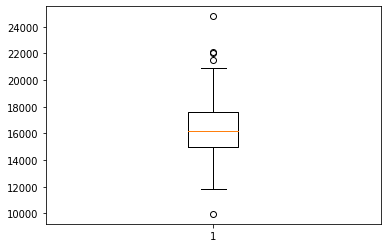

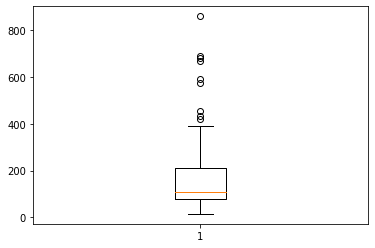

In [245]:
plt.boxplot(cs['diff1_3_c2'])
plt.show()
plt.boxplot(cs['diff2_3_c2'])
plt.show()

In [224]:
print(np.mean(cs['diff1_2_c2']))
print(np.mean(cs['diff1_3_c2']))
print(np.mean(cs['diff2_3_c2']))

31304.17
130.73
965.1


In [225]:
print(np.mean(cs['diff1_2_c1']))
print(np.mean(cs['diff1_3_c1']))
print(np.mean(cs['diff2_3_c1']))

31304.17
130.73
965.1


In [209]:
print(np.mean(cs['diff1_2_c0']))
print(np.mean(cs['diff1_3_c0']))
print(np.mean(cs['diff2_3_c0']))

457100.8
41080.0
20219.2


In [ ]:
return_preidction()